In [36]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
# Read the input dataset
dataset = pd.read_csv('AirPassengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
dataset.head()

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [38]:
# Set the month as Index and Create Time Series.
ts = dataset.set_index(['Month'])
ts.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


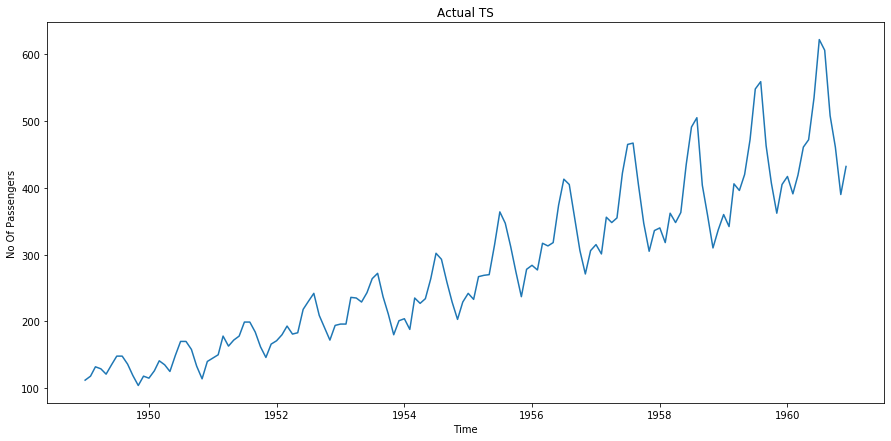

In [39]:
# Stationarity check of time series:
#     1. Constant Mean.
#     2. Constant Variance.
#     3. AutoCovariance is not a function of time.
# Fisrt have a visual look of the data below.
plt.figure(figsize=(15,7))
plt.plot(ts)
plt.xlabel('Time')
plt.ylabel('No Of Passengers')
plt.title('Actual TS')
plt.show()

Test Statistic                  0.815369
p-value                         0.991880
#Lags used                     13.000000
Number of observation used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


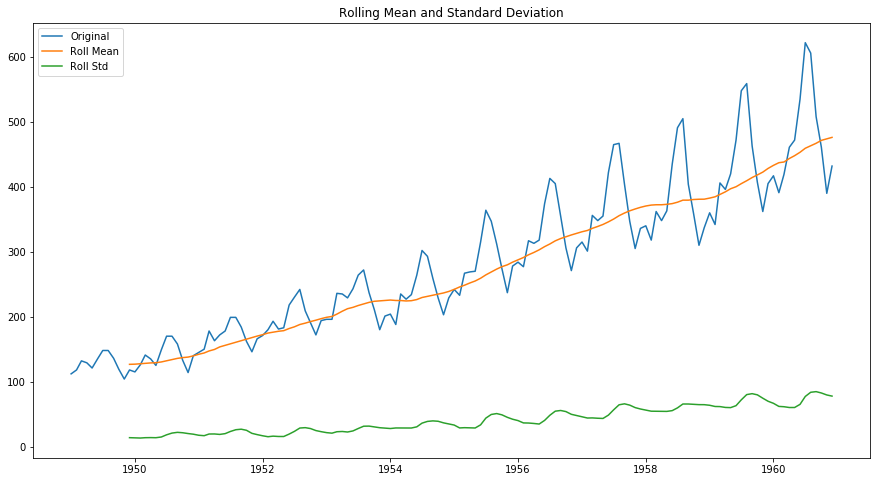

In [40]:
# Define a function which will perform Rolling Statistics & Dicky Fuller Test on th TS.
from statsmodels.tsa.stattools import adfuller

def test_stationary(ts):
    
    # Calculate Rolling Statistics.
    rolmean = ts.rolling(window=12).mean()
    rolstd = ts.rolling(window=12).std()
    # Plot Rolling Statistics.
    plt.figure(figsize=(15,8))
    plt.plot(ts, label='Original')
    plt.plot(rolmean, label='Roll Mean')
    plt.plot(rolstd, label='Roll Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    # Perform Dicky Fuller Test
    dftest = adfuller(ts['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags used','Number of observation used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

test_stationary(ts)

In [ ]:
# From above, the std is a bit stationary, but mean is increasing with time. Hence Non-Stationary
# From dicy fuller test also, the Test Statistic value is very much larger then the Critical values.
# So the TS is made Stationary by removing Trend And Seasonality.

# Eliminating Trend:
#     1. Apply transformation like log, square or Cube root etc.
#     2. Remove the trend by below common methoods:
#         a. Aggregation.
#         b. Ploynomial Fitting.
#         c. Smoothing.
#         d. Differencing.
#         e. Decomposition.
# Here we will Apply Log, Smoothing using Moving Avg/Exponential Moving Avg, Differencing and Decomposition 

Test Statistic                 -1.717017
p-value                         0.422367
#Lags used                     13.000000
Number of observation used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


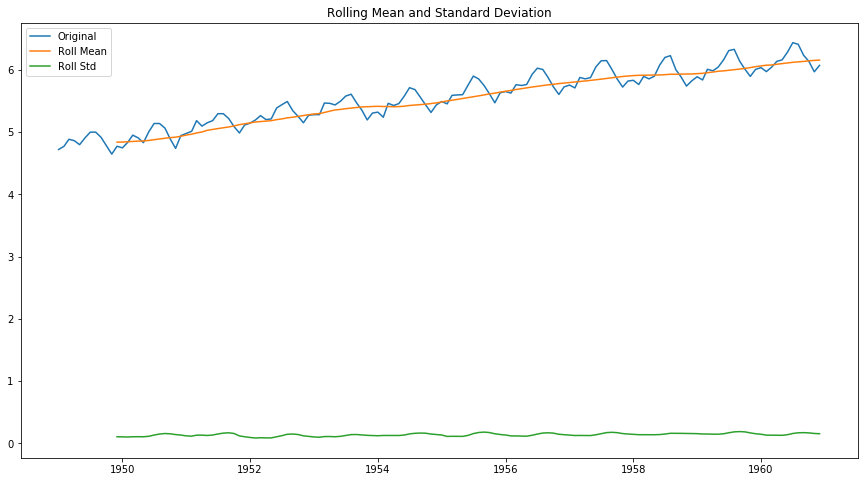

In [42]:
# Apply log to TS
ts_log = np.log(ts)
test_stationary(ts_log)

In [80]:
# From above , applying only log does not make the TS stationary.
# Hence applying moving-avg to log. Only applying moving-avg will also result in similar graph above.
# So moving for log and moving-avg and test stationary.
ts_log_movingavg = ts_log.rolling(window=12).mean()
ts_log_movingavg.head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN


In [81]:
# Calulate log and Moving avg diff and test_stationary
ts_log_movingavg_diff = ts_log - ts_log_movingavg
ts_log_movingavg_diff.isna().sum()

#Passengers    11
dtype: int64

In [82]:
ts_log_movingavg_diff.dropna(inplace=True)
ts_log_movingavg_diff.isna().sum()

#Passengers    0
dtype: int64

Test Statistic                 -3.162908
p-value                         0.022235
#Lags used                     13.000000
Number of observation used    119.000000
Critical Value (1%)            -3.486535
Critical Value (5%)            -2.886151
Critical Value (10%)           -2.579896
dtype: float64


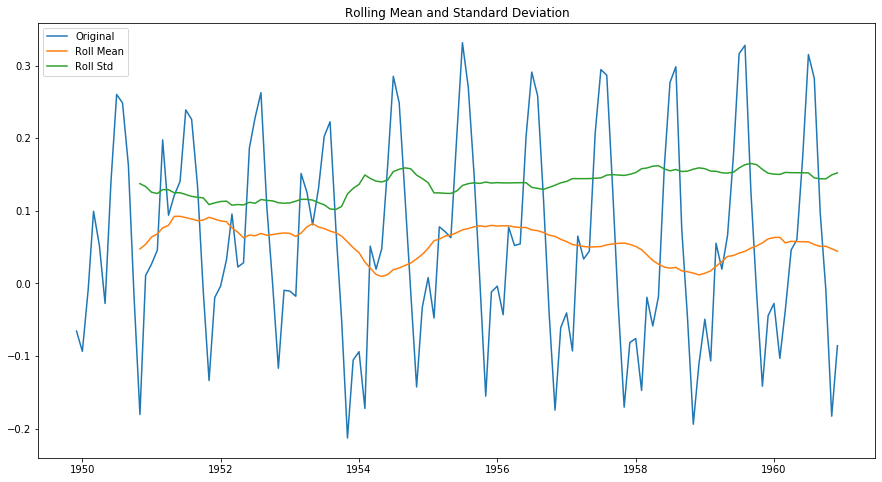

In [83]:
test_stationary(ts_log_movingavg_diff)

Test Statistic                 -3.601262
p-value                         0.005737
#Lags used                     13.000000
Number of observation used    130.000000
Critical Value (1%)            -3.481682
Critical Value (5%)            -2.884042
Critical Value (10%)           -2.578770
dtype: float64


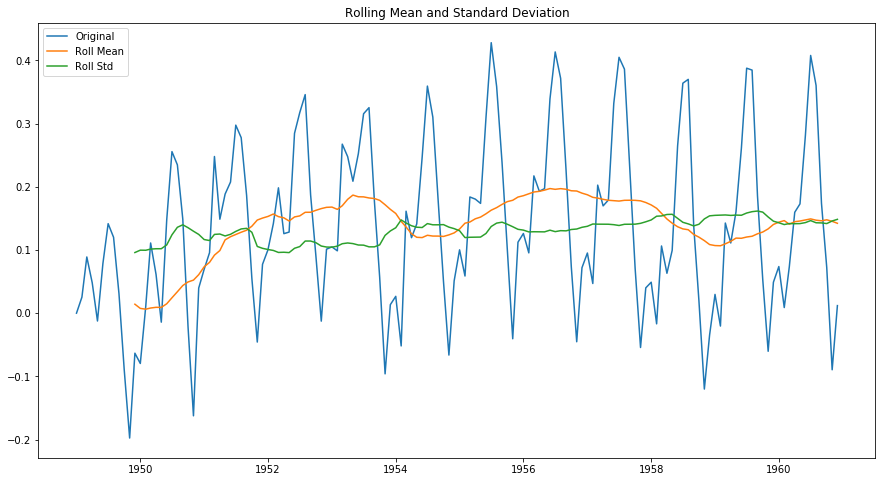

In [93]:
# From above the Test Statistic is < 5% critical value. Hence ts_log_movingavg_diff is 95% stationary.
# Trying with exponential weighted moving avg, then diff and test stationary.
ts_log_ewm = ts_log.ewm(halflife=12).mean()
ts_log_ewm_diff = ts_log - ts_log_ewm
test_stationary(ts_log_ewm_diff)

In [94]:
# From above two benefits:
#     1. No NAN values to be discared.
#     2. Test statistic < 1% Critical value. Hence test_log_ewm_diff is stationary and can be proceeded with models.

Test Statistic                 -2.717131
p-value                         0.071121
#Lags used                     14.000000
Number of observation used    128.000000
Critical Value (1%)            -3.482501
Critical Value (5%)            -2.884398
Critical Value (10%)           -2.578960
dtype: float64


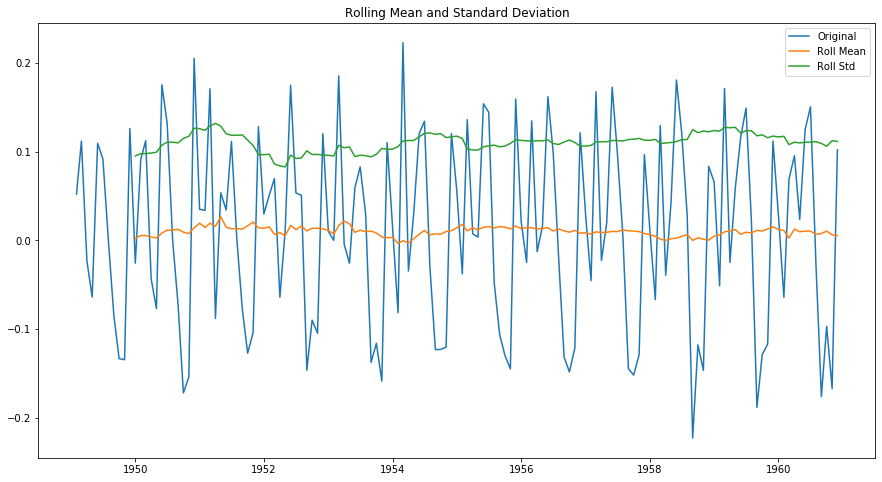

In [108]:
# The above technique may not apply to all the cases as here. 
# Hence moving to some better technique to remove Trend and Seasonality both at same time as below:
#     1. Difference by shifting.
#     2. Decomposition.
#
# 1. Differencing by shifting - Here trying with period 2 and test stationary.
ts_log_shift_diff = ts_log - ts_log.shift(1)
ts_log_shift_diff.dropna(inplace=True)
test_stationary(ts_log_shift_diff)

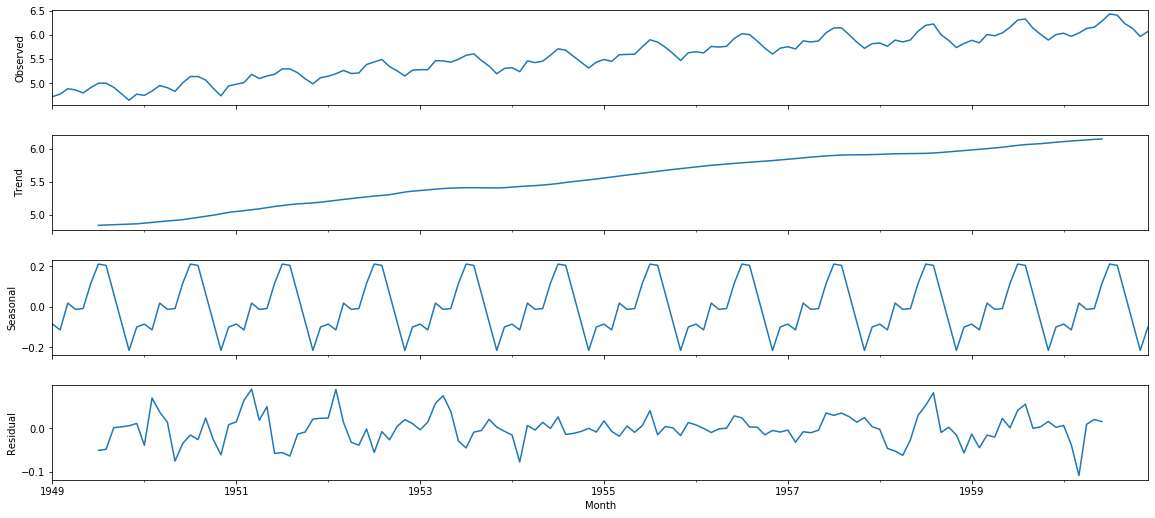

In [116]:
# The above gives some better result with 90% stationary.
# Hence try with second techinque as Decomposing
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_log)
fig = decomposition.plot()
fig.set_size_inches(18, 8)
plt.show()

Test Statistic               -6.332387e+00
p-value                       2.885059e-08
#Lags used                    9.000000e+00
Number of observation used    1.220000e+02
Critical Value (1%)          -3.485122e+00
Critical Value (5%)          -2.885538e+00
Critical Value (10%)         -2.579569e+00
dtype: float64


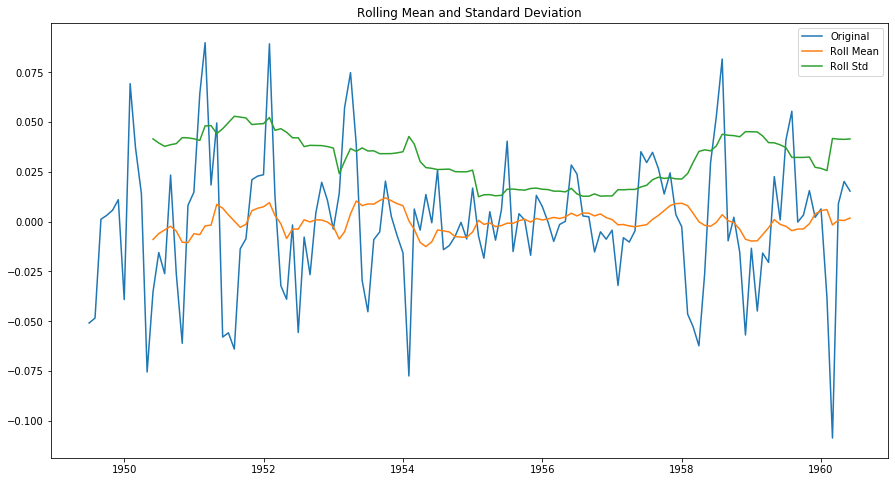

In [122]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
# We will consider residual for further testing stationary.
residual.dropna(inplace=True)
test_stationary(residual)

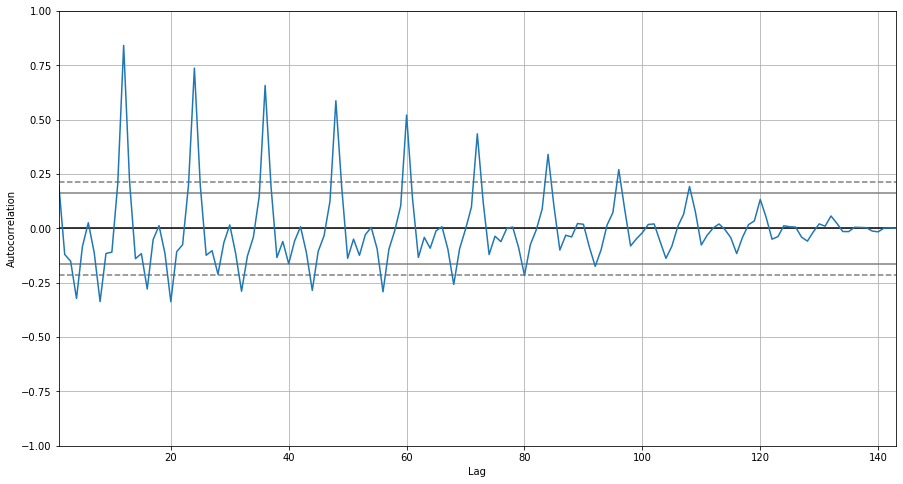

<Figure size 1080x576 with 0 Axes>

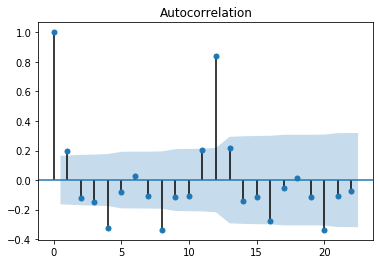

<Figure size 1080x576 with 0 Axes>

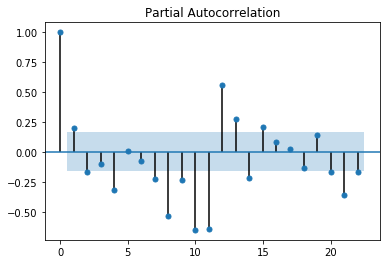

In [155]:
# Lets move on to ARIMA model using differencing as here reverting back to original data is easier.
# For ARIMA, need to determine value of p, q and d. 
# For determining p and q, we use ACF and PACF graph as below.
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(15,8))
autocorrelation_plot(ts_log_shift_diff)
plt.show()

plt.figure(figsize=(15,8))
plot_acf(ts_log_shift_diff)
plt.show()

plt.figure(figsize=(15,8))
plot_pacf(ts_log_shift_diff)
plt.show()

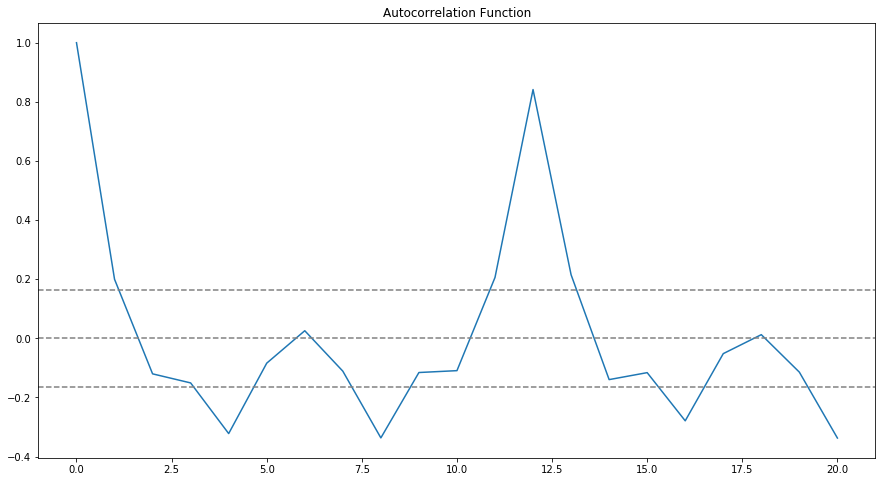

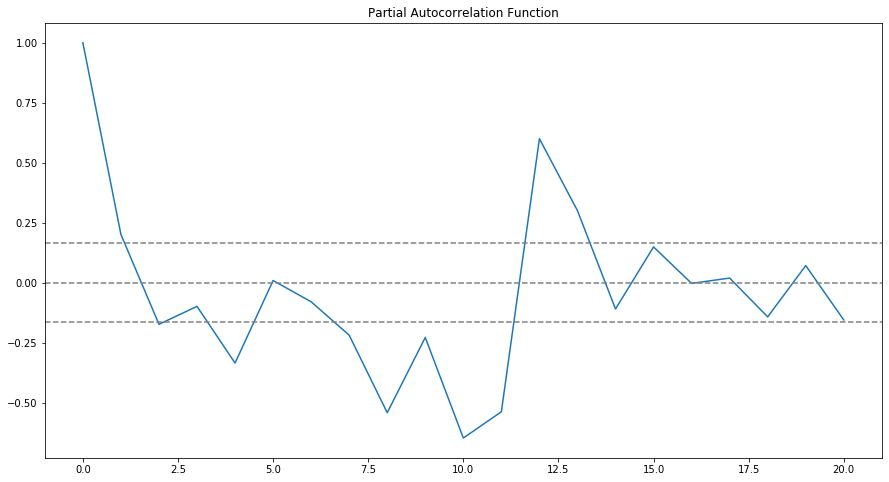

In [157]:
# We can also use below.
from statsmodels.tsa.stattools import acf, pacf

acf_ts_log_shift_diff = acf(ts_log_shift_diff, nlags=20, fft=False)
pacf_ts_log_shift_diff = pacf(ts_log_shift_diff, nlags=20, method='ols')

plt.figure(figsize=(15,8))
plt.plot(acf_ts_log_shift_diff)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

plt.figure(figsize=(15,8))
plt.plot(pacf_ts_log_shift_diff)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_shift_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [188]:
# From the above graphs value of p = 2(from PCAF) and q = 2(from ACF). From before we are considering d=1
# start ARIMA model with (p,d,q) = (2,1,2)
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Abhilash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Abhilash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS of AR: 1.5023')

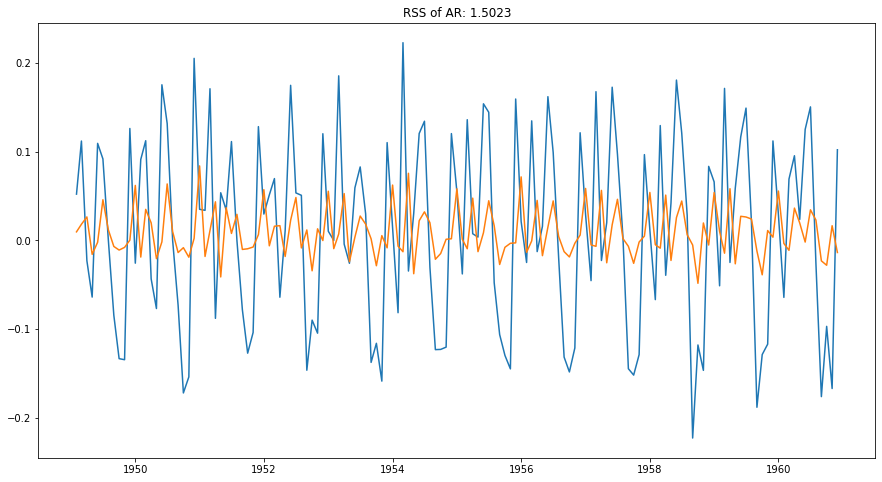

In [197]:
# AR model
model = ARIMA(ts_log, order=(2,1,0))
predict_AR = model.fit(disp=-1, missing="drop")
rss=0
for i in range(len(predict_AR.fittedvalues)):
    rss += (predict_AR.fittedvalues.iloc[i] - ts_log_shift_diff.iloc[i])**2

plt.figure(figsize=(15,8))
plt.plot(ts_log_shift_diff)
plt.plot(predict_AR.fittedvalues)
plt.title('RSS of AR: %.4f'% rss)

C:\Users\Abhilash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Abhilash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS of MA: 1.4721')

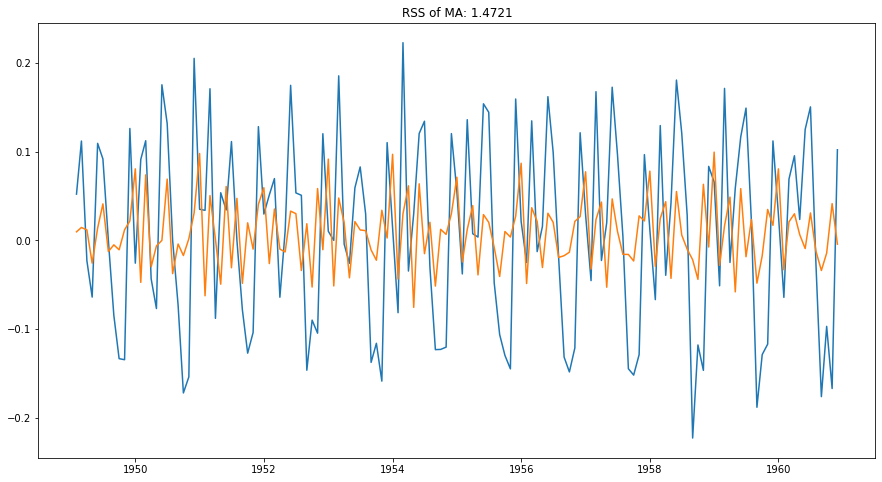

In [198]:
# MA model
model = ARIMA(ts_log, order=(0,1,2))
predict_MA = model.fit(disp=-1, missing="drop")
rss=0
for i in range(len(predict_MA.fittedvalues)):
    rss += (predict_MA.fittedvalues.iloc[i] - ts_log_shift_diff.iloc[i])**2

plt.figure(figsize=(15,8))
plt.plot(ts_log_shift_diff)
plt.plot(predict_MA.fittedvalues)
plt.title('RSS of MA: %.4f'% rss)

C:\Users\Abhilash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Abhilash\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS of ARIMA: 1.0292')

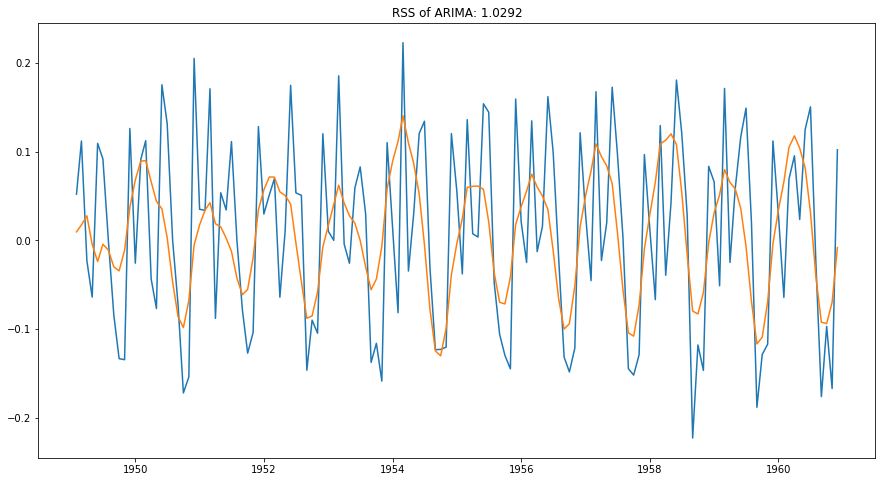

In [199]:
# Combined Model
model = ARIMA(ts_log, order=(2,1,2))
predict_ARIMA = model.fit(disp=-1, missing="drop")
rss=0
for i in range(len(predict_ARIMA.fittedvalues)):
    rss += (predict_ARIMA.fittedvalues.iloc[i] - ts_log_shift_diff.iloc[i])**2

plt.figure(figsize=(15,8))
plt.plot(ts_log_shift_diff)
plt.plot(predict_ARIMA.fittedvalues)
plt.title('RSS of ARIMA: %.4f'% rss)

In [201]:
# From the above the ARIMA combined model is having least RSS. Hence best.